# Immgen PRJNA392905 - ATAC-Seq SPAN, MACS2 replicates consistency

Logbook: https://docs.google.com/document/d/1WxzLWUX0PV2TpD0VfwStHczN6YSQ35Uu6DDR-8WX-io/edit#heading=h.xg4nq1px6lhh

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tqdm.auto import tqdm
import tempfile
import re
from itertools import product

In [2]:
PATH = os.path.expanduser('~/data/2023_Immgen')
! mkdir -p {PATH}/pics

def file_to_name(file):
    return re.sub('(.*SRR[0-9]+_)|(_ATAC_seq.*)', '', os.path.basename(file))

def file_to_srr(file):
    return re.sub('_.*', '', os.path.basename(file))

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0) # Empty file

def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0 # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

# Macs2

In [5]:
MACS2_FOLDER = PATH + '/macs2'
LEVELS = ['0.1']

dfma = pd.DataFrame(columns=['srr', 'name', 'tool', 'file', 'peaks'], dtype=object)

for file in tqdm(glob.glob(MACS2_FOLDER + '/*.broadPeak')):
    tool = next((l for l in LEVELS if f'{l}_' in file), None)
    if tool:
        name = file_to_name(file)
        srr = file_to_srr(file)
        dfma.loc[len(dfma)] = (srr, name, f'MACS2 broad {tool}', file, lines(file))

dfma['peaks'] = dfma['peaks'].astype(int)

  0%|          | 0/185 [00:00<?, ?it/s]

In [6]:
MACS2_FOLDER = PATH + '/macs2'
LEVELS = ['q0.05']

dfm = pd.DataFrame(columns=['srr', 'name', 'tool', 'file', 'peaks'], dtype=object)

for file in tqdm(glob.glob(MACS2_FOLDER + '/*.narrowPeak')):
    tool = next((l for l in LEVELS if f'{l}_' in file), None)
    if tool:
        name = file_to_name(file)
        srr = file_to_srr(file)
        dfm.loc[len(dfm)] = (srr, name, f'MACS2 {tool}', file, lines(file))

dfm['peaks'] = dfm['peaks'].astype(int)

  0%|          | 0/185 [00:00<?, ?it/s]

# SPAN

In [7]:
SPAN_FOLDER=PATH + '/span'
FDRS = [0.05]

dfs = pd.DataFrame(columns=['srr', 'name', 'tool', 'file', 'peaks'], dtype=object)

for file in tqdm(glob.glob(SPAN_FOLDER + '/*.peak')):
    fdr = next((f for f in FDRS if f'{f}' in file), None)
    if fdr:
        name = file_to_name(file)
        srr = file_to_srr(file)
        dfs.loc[len(dfs)] = (srr, name, f'SPAN {fdr}', file, lines(file))

dfs['peaks'] = dfs['peaks'].astype(int)

  0%|          | 0/185 [00:00<?, ?it/s]

In [8]:
# SPAN_FOLDER=PATH + '/span_atac'
# FDRS = [0.05]
#
# dfsa = pd.DataFrame(columns=['srr', 'name', 'tool', 'file', 'peaks'], dtype=object)
#
# for file in tqdm(glob.glob(SPAN_FOLDER + '/*00*.peak')):
#     fdr = next((f for f in FDRS if f'_q{f}' in file), None)
#     if fdr:
#         name = file_to_name(file)
#         srr = file_to_srr(file)
#         dfsa.loc[len(dfsa)] = (srr, name, f'SPAN fragment {fdr}', file, lines(file))
#
# dfsa['peaks'] = dfsa['peaks'].astype(int)

In [9]:
# dfa = pd.concat([dfma, dfm, dfs, dfsa])
dfa = pd.concat([dfma, dfm, dfs, dfs]).reset_index(drop=True)

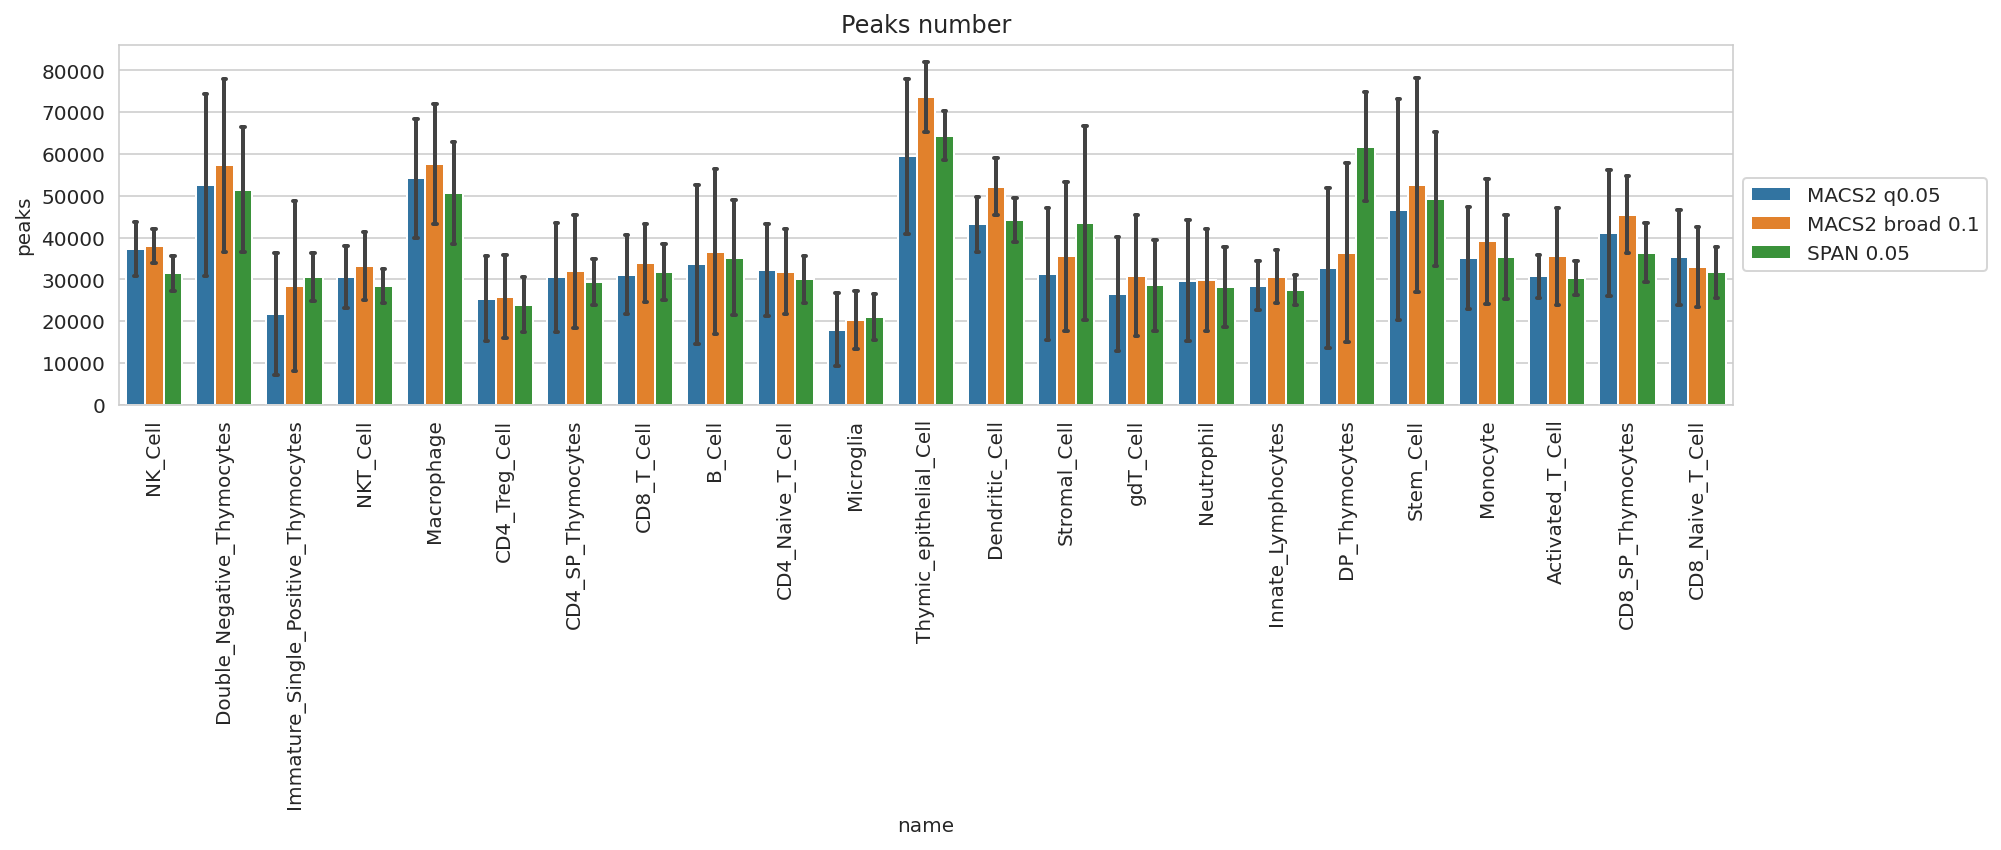

In [10]:
plt.figure(figsize=(14, 6))
g_result = sns.barplot(data=dfa, x='name', y='peaks', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2,
                       hue_order=['MACS2 q0.05', 'MACS2 broad 0.1', 'SPAN 0.05'])
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title('Peaks number')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
dfa = dfa[(dfa['name'] != 'DP_Thymocytes') & (dfa['name'] != 'Immature_Single_Positive_Thymocytes')].copy()

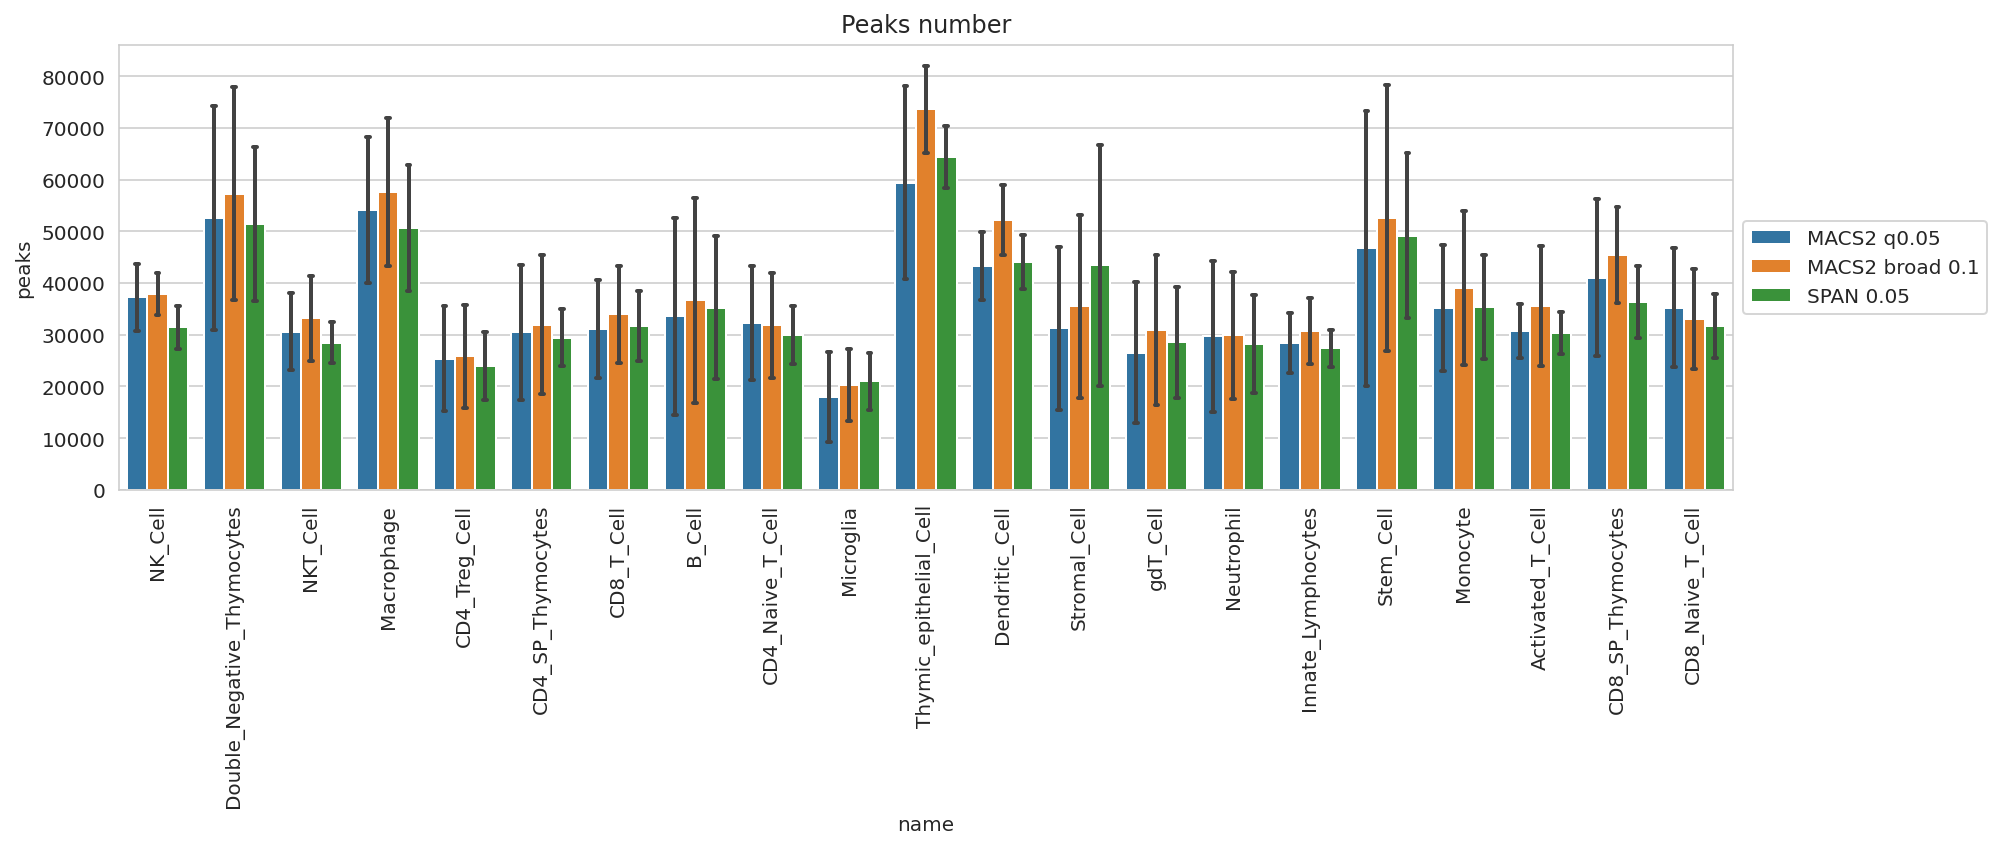

In [12]:
plt.figure(figsize=(14, 6))
g_result = sns.barplot(data=dfa, x='name', y='peaks', hue='tool',
                       errorbar='sd', capsize=.05, errwidth=2,
                       hue_order=['MACS2 q0.05', 'MACS2 broad 0.1', 'SPAN 0.05'])
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title('Peaks number')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

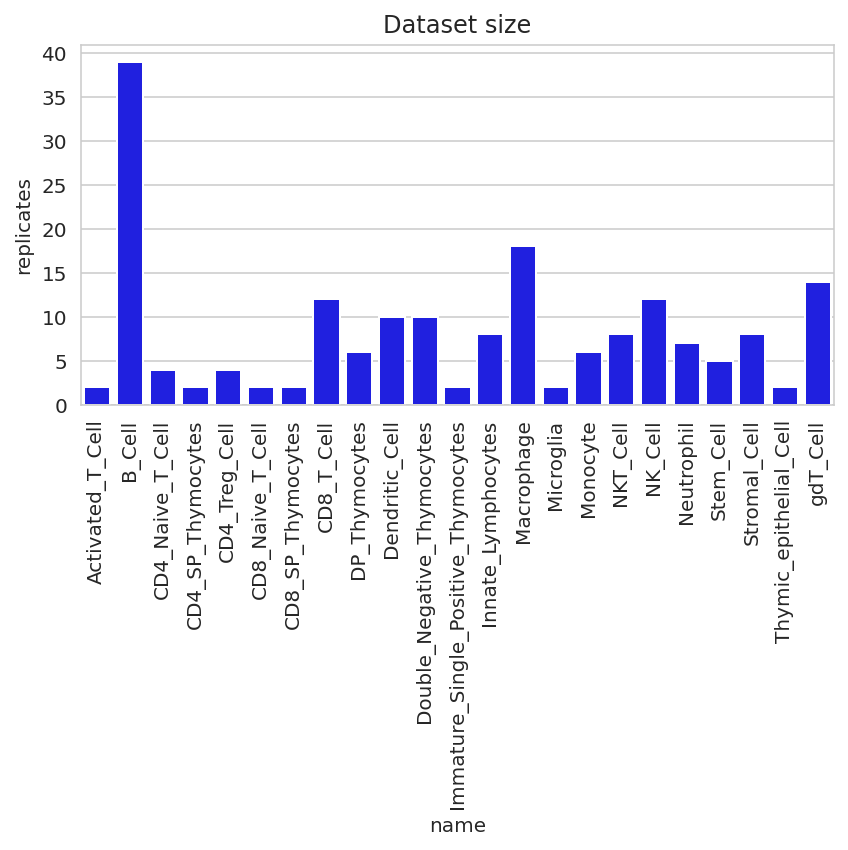

In [13]:
t = (dfm.groupby(['name'])['file'].count() / len(LEVELS)).astype(int)
plt.figure(figsize=(6, 6))
sns.barplot(data=pd.DataFrame(dict(name=t.index, replicates=t)), x='name', y='replicates', color='Blue')
plt.xticks(rotation=90)
plt.title('Dataset size')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/replicates.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
ts = []
for name, tool, file in tqdm(zip(dfa['name'], dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(name=[name] * len(lengths), tool=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,name,tool,length
5204202,NK_Cell,SPAN 0.05,376
5236774,B_Cell,SPAN 0.05,384
7022900,gdT_Cell,SPAN 0.05,195
6447939,gdT_Cell,SPAN 0.05,145
6795590,Macrophage,SPAN 0.05,1174
1047378,B_Cell,MACS2 broad 0.1,650
3700379,Neutrophil,SPAN 0.05,75
2200913,B_Cell,MACS2 q0.05,164
6595081,B_Cell,SPAN 0.05,518
5227953,B_Cell,SPAN 0.05,992


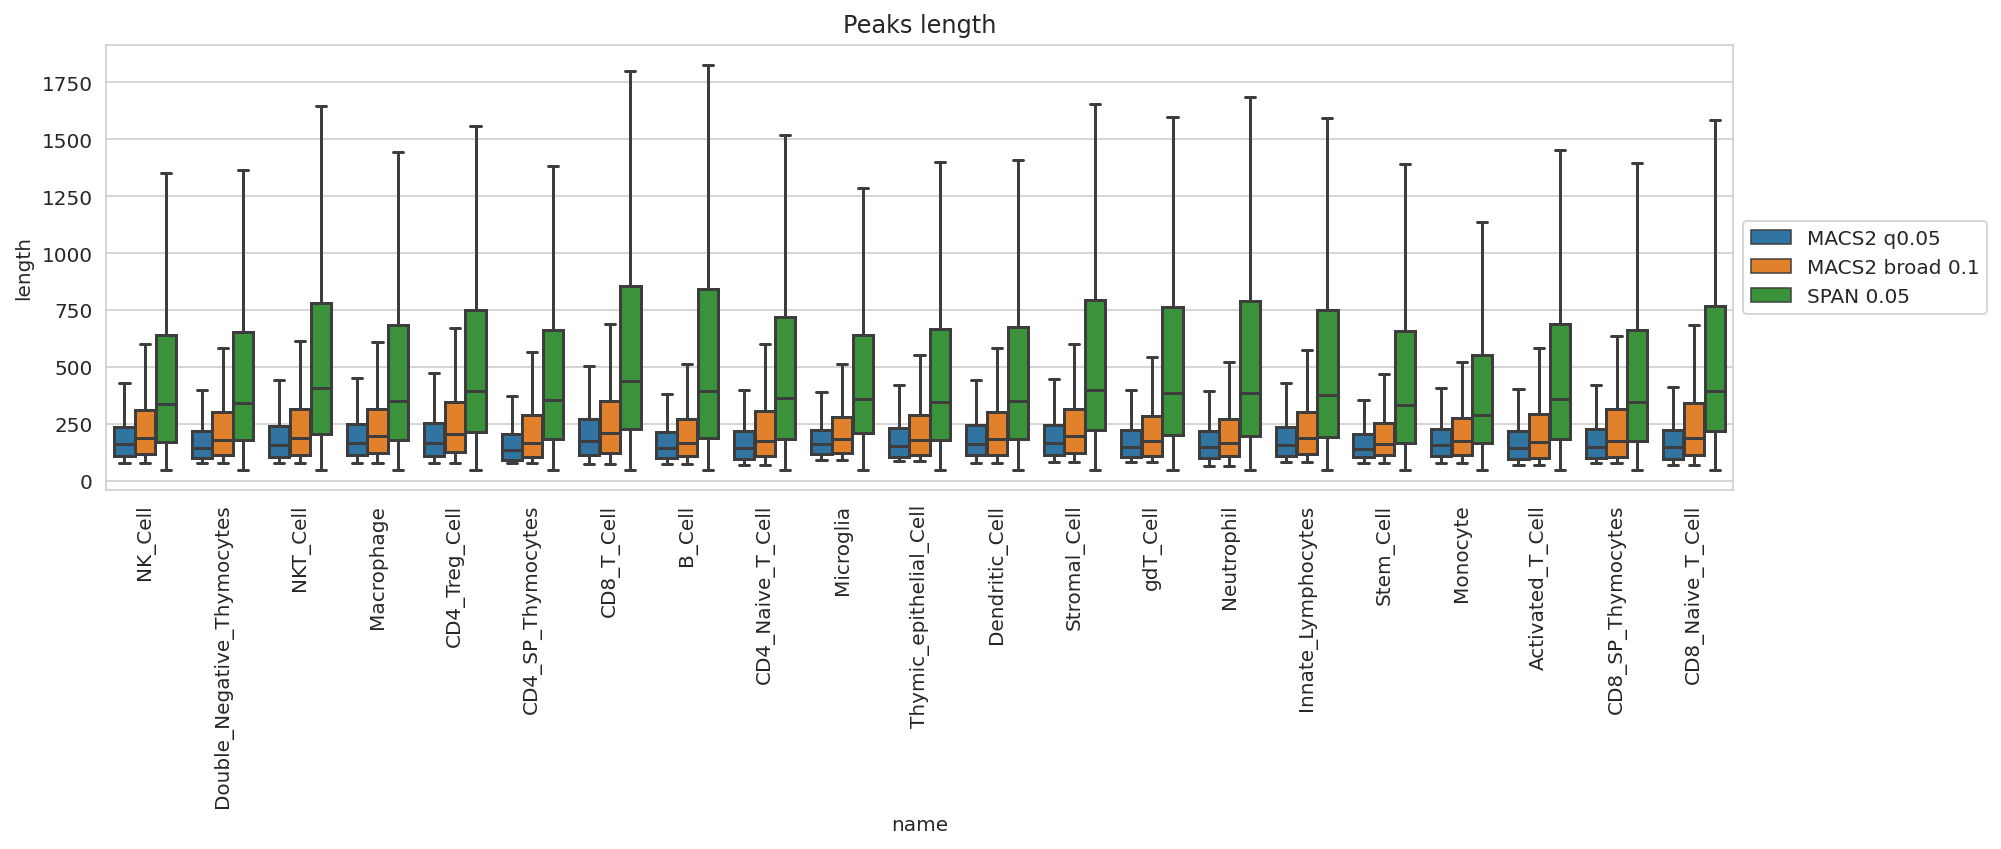

In [15]:
plt.figure(figsize=(14, 6))
g_result = sns.boxplot(data=t, x='name', y='length', hue='tool', showfliers=False,
                       hue_order=['MACS2 q0.05', 'MACS2 broad 0.1', 'SPAN 0.05'])
plt.xticks(rotation=90)
plt.title('Peaks length')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

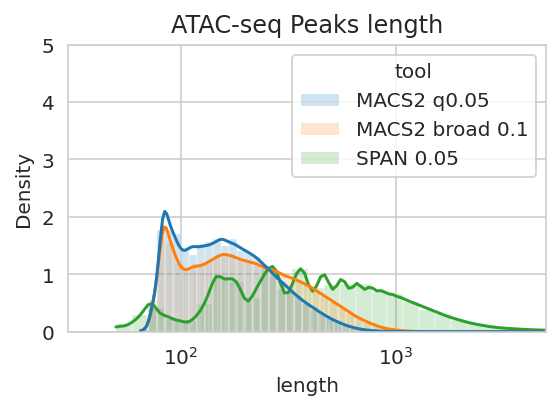

In [16]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['MACS2 q0.05', 'MACS2 broad 0.1', 'SPAN 0.05'])
g_results.set(xscale='log')
g_results.set_ylim(0, 5)
g_results.set_xlim(30, 5e3)
ax.title.set_text('ATAC-seq Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_length2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Overlaps

In [143]:
! mkdir {PATH}/overlaps

def compute_overlaps(df):
    dfoverlap = pd.DataFrame(columns=['name', 'tool', 'file1', 'file2',
                                      'peaks1', 'peaks2', 'overlap12', 'overlap21',
                                      'peaks1_len', 'peaks2_len', 'overlap_len'], dtype=object)
    for n in sorted(set(df['name'])):
        for tool in sorted(set(df['tool'])):
            dfnl = df.loc[(df['name'] == n) &  (df['tool'] == tool)]
            print('Processing', n, tool, len(dfnl))
            files = list(dfnl['file'])
            for i1, i2 in tqdm(product(range(len(files)), range(len(files)))):
                if i1 >= i2:
                    continue
                f1, f2 = files[i1], files[i2]
                peaks1, peaks1_len = lines(f1), bedl(f1).sum()
                peaks2, peaks2_len = lines(f2), bedl(f2).sum()
                f1s, f2s = sorted_file(f1), sorted_file(f2)
                tf = f'{PATH}/overlaps/overlaps_{tool}_{n}_{tool}_overlaps.bed'.replace(' ', '_')
                !bedtools intersect -a {f1s} -b {f2s} -wa -u > {tf}
                overlap12 = lines(tf)
                !bedtools intersect -b {f1s} -a {f2s} -wa -u > {tf}
                overlap21 = lines(tf)
                !bedtools intersect -a {f1s} -b {f2s} -wo > {tf}
                overlap_len = int(last_col(tf).sum())
                dfoverlap.loc[len(dfoverlap)] = (n, tool, f1, f2,
                                                 peaks1, peaks2, overlap12, overlap21,
                                                 peaks1_len, peaks2_len, overlap_len)
    return dfoverlap

## MACS2 overlaps

In [144]:
dfma_overlap = compute_overlaps(dfma)

Processing Activated_T_Cell MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing B_Cell MACS2 broad 0.1 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell MACS2 broad 0.1 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell MACS2 broad 0.1 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing CD8_T_Cell MACS2 broad 0.1 12


0it [00:00, ?it/s]

Processing DP_Thymocytes MACS2 broad 0.1 6


0it [00:00, ?it/s]

Processing Dendritic_Cell MACS2 broad 0.1 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes MACS2 broad 0.1 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes MACS2 broad 0.1 8


0it [00:00, ?it/s]

Processing Macrophage MACS2 broad 0.1 18


0it [00:00, ?it/s]

Processing Microglia MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing Monocyte MACS2 broad 0.1 6


0it [00:00, ?it/s]

Processing NKT_Cell MACS2 broad 0.1 8


0it [00:00, ?it/s]

Processing NK_Cell MACS2 broad 0.1 12


0it [00:00, ?it/s]

Processing Neutrophil MACS2 broad 0.1 7


0it [00:00, ?it/s]

Processing Stem_Cell MACS2 broad 0.1 5


0it [00:00, ?it/s]

Processing Stromal_Cell MACS2 broad 0.1 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing gdT_Cell MACS2 broad 0.1 14


0it [00:00, ?it/s]

In [145]:
dfm_overlap = compute_overlaps(dfm)

Processing Activated_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing B_Cell MACS2 q0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes MACS2 q0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Macrophage MACS2 q0.05 18


0it [00:00, ?it/s]

Processing Microglia MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Monocyte MACS2 q0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing NK_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing Neutrophil MACS2 q0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell MACS2 q0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell MACS2 q0.05 14


0it [00:00, ?it/s]

## SPAN overlaps

In [146]:
dfs_overlap = compute_overlaps(dfs)

Processing Activated_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing B_Cell SPAN 0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes SPAN 0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell SPAN 0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes SPAN 0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes SPAN 0.05 8


0it [00:00, ?it/s]

Processing Macrophage SPAN 0.05 18


0it [00:00, ?it/s]

Processing Microglia SPAN 0.05 2


0it [00:00, ?it/s]

Processing Monocyte SPAN 0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing NK_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing Neutrophil SPAN 0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell SPAN 0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell SPAN 0.05 14


0it [00:00, ?it/s]

In [147]:
# dfsa_overlap = compute_overlaps(dfsa)

In [148]:
# dfao = pd.concat([dfma_overlap, dfm_overlap, dfs_overlap, dfsa_overlap])
dfao = pd.concat([dfma_overlap, dfm_overlap, dfs_overlap])
dfao['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(dfao['peaks1_len'], dfao['peaks2_len'], dfao['overlap_len'])
]

Jaccard


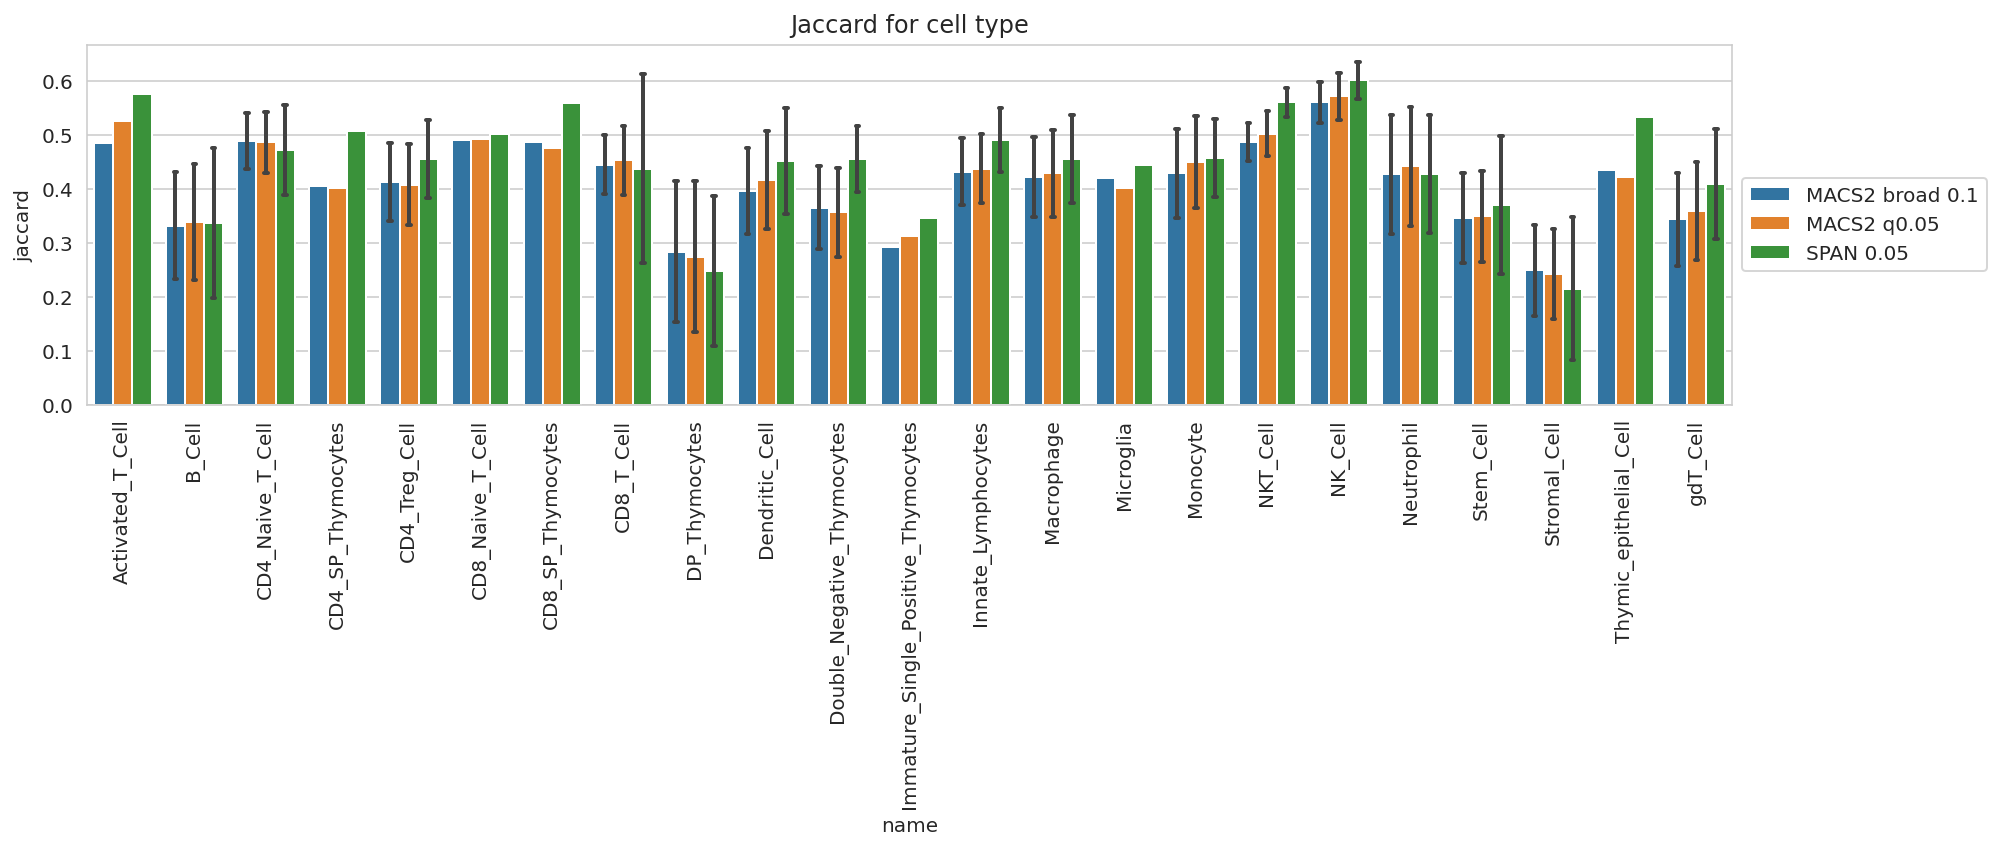

In [158]:
print('Jaccard')

plt.figure(figsize=(14, 6))
g_result = sns.barplot(data=dfao,
            x='name', y='jaccard', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2)
plt.xticks(rotation=90)
plt.title('Jaccard for cell type')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

## IDR between replicates

In [23]:
from tempfile import mktemp

def compute_idrs(df):
    dfidr = pd.DataFrame(columns=['name', 'tool', 'rep1', 'rep2', 
                                  'idr_peaks', 'idr_loaded_peaks', 'idr_percentage'], dtype=object)
    tf = mktemp()
    for n in sorted(set(df['name'])):
        for tool in sorted(set(df['tool'])):
            dfnl = df.loc[(df['name'] == n) &  (df['tool'] == tool)]
            print('Processing', n, tool, len(dfnl))
            files = list(dfnl['file'])
            for i1, i2 in tqdm(product(range(len(files)), range(len(files)))):
                if i1 >= i2:
                    continue
                f1, f2 = sorted_file(files[i1]), sorted_file(files[i2])
                # Process SICER peaks, add missing 8th column, as -log10 qvalue
                if tool == 'SICER':
                    sf1 = pd.read_csv(f1, sep='\t', header=None)
                    sf1[8] = -np.log10(sf1[7])
                    sf1.to_csv(f1, sep='\t', index=None, header=False)
                    sf2 = pd.read_csv(f2, sep='\t', header=None)
                    sf2[8] = -np.log10(sf2[7])
                    sf2.to_csv(f2, sep='\t', index=None, header=False)
                ! idr --input-file-type bed --rank 8 --samples {f1} {f2} 2>&1 | tee {tf}
                with open(tf) as f:
                    idr_out = f.read()
                ip, ilp, iperc = re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)', idr_out)[0]
                ip, ilp, iperc = int(ip), int(ilp), float(iperc)                
                dfidr.loc[len(dfidr)] = (n, tool, i1, i2, ip, ilp, iperc)
    return dfidr

In [ ]:
dfma_idr = compute_idrs(dfma)

Processing Activated_T_Cell MACS2 broad 0.1 2


0it [00:00, ?it/s]

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.44 0.90 0.64 0.61]
Number of reported peaks - 23601/23601 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 10525/23601 (44.6%)

Processing B_Cell MACS2 broad 0.1 39


0it [00:00, ?it/s]

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.04 0.99 0.57 0.58]
Number of reported peaks - 24203/24203 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 5616/24203 (23.2%)

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.90 1.01 0.66 0.60]
Number of reported peaks - 25676/25676 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 5392/25676 (21.0%)

/home/jetbrains/minico

In [ ]:
dfm_idr = compute_idrs(dfm)

In [ ]:
dfs_idr = compute_idrs(dfs)

In [27]:
dfai = pd.concat([dfma_idr, dfm_idr, dfs_idr])

NameError: name 'dfm_idr' is not defined

In [26]:
print('IDR')

plt.figure(figsize=(14, 6))
g_result = sns.barplot(data=dfai,
                       x='name', y='idr_peaks', hue='tool',
                       errorbar='sd', capsize=.05, errwidth=2)
plt.xticks(rotation=90)
plt.title('IDR for cell type')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/idr.pdf', bbox_inches='tight', dpi=300)
plt.show()

IDR


NameError: name 'dfai' is not defined

<Figure size 1008x432 with 0 Axes>

# Overlap with DHS

In [150]:
from itertools import product

DHS_PATH = sorted_file(f'{PATH}/ENCFF754WCT_mm10_dhs_representative_sites.bed')
DHS_PEAKS = lines(DHS_PATH)

def compute_dhs_overlaps(df):
    dfoverlap = pd.DataFrame(columns=['name', 'tool', 'file', 'way', 'peaks', 'overlap'], dtype=object)
    for n in sorted(set(df['name'])):
        for tool in sorted(set(df['tool'])):
            dfnl = df.loc[(df['name'] == n) &  (df['tool'] == tool)]
            print('Processing', n, tool, len(dfnl))
            for _, row in tqdm(dfnl.iterrows()):
                file, peaks = sorted_file(row['file']), row['peaks']

                tf = f'{PATH}/overlaps/overlaps_{tool}_{n}_{tool}_vs_dhs.bed'.replace(' ', '_')
                !bedtools intersect -a {file} -b {DHS_PATH} -wa -u > {tf}
                owd = lines(tf)
                dfoverlap.loc[len(dfoverlap)] = (n, tool, file, 'with_dhs', peaks, owd)

                tf = f'{PATH}/overlaps/overlaps_{tool}_{n}_{tool}_dhs_vs.bed'.replace(' ', '_')
                !bedtools intersect -b {file} -a {DHS_PATH} -wa -u > {tf}
                odw = lines(tf)
                dfoverlap.loc[len(dfoverlap)] = (n, tool, file, 'dhs_with', DHS_PEAKS, odw)
    return dfoverlap

In [151]:
dfma_dhs_overlap = compute_dhs_overlaps(dfma)

Processing Activated_T_Cell MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing B_Cell MACS2 broad 0.1 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell MACS2 broad 0.1 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell MACS2 broad 0.1 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing CD8_T_Cell MACS2 broad 0.1 12


0it [00:00, ?it/s]

Processing DP_Thymocytes MACS2 broad 0.1 6


0it [00:00, ?it/s]

Processing Dendritic_Cell MACS2 broad 0.1 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes MACS2 broad 0.1 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes MACS2 broad 0.1 8


0it [00:00, ?it/s]

Processing Macrophage MACS2 broad 0.1 18


0it [00:00, ?it/s]

Processing Microglia MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing Monocyte MACS2 broad 0.1 6


0it [00:00, ?it/s]

Processing NKT_Cell MACS2 broad 0.1 8


0it [00:00, ?it/s]

Processing NK_Cell MACS2 broad 0.1 12


0it [00:00, ?it/s]

Processing Neutrophil MACS2 broad 0.1 7


0it [00:00, ?it/s]

Processing Stem_Cell MACS2 broad 0.1 5


0it [00:00, ?it/s]

Processing Stromal_Cell MACS2 broad 0.1 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell MACS2 broad 0.1 2


0it [00:00, ?it/s]

Processing gdT_Cell MACS2 broad 0.1 14


0it [00:00, ?it/s]

In [152]:
dfm_dhs_overlap = compute_dhs_overlaps(dfm)

Processing Activated_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing B_Cell MACS2 q0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell MACS2 q0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes MACS2 q0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes MACS2 q0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Macrophage MACS2 q0.05 18


0it [00:00, ?it/s]

Processing Microglia MACS2 q0.05 2


0it [00:00, ?it/s]

Processing Monocyte MACS2 q0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing NK_Cell MACS2 q0.05 12


0it [00:00, ?it/s]

Processing Neutrophil MACS2 q0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell MACS2 q0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell MACS2 q0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell MACS2 q0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell MACS2 q0.05 14


0it [00:00, ?it/s]

In [153]:
dfs_dhs_overlap = compute_dhs_overlaps(dfs)

Processing Activated_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing B_Cell SPAN 0.05 39


0it [00:00, ?it/s]

Processing CD4_Naive_T_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD4_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD4_Treg_Cell SPAN 0.05 4


0it [00:00, ?it/s]

Processing CD8_Naive_T_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_SP_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing CD8_T_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing DP_Thymocytes SPAN 0.05 6


0it [00:00, ?it/s]

Processing Dendritic_Cell SPAN 0.05 10


0it [00:00, ?it/s]

Processing Double_Negative_Thymocytes SPAN 0.05 10


0it [00:00, ?it/s]

Processing Immature_Single_Positive_Thymocytes SPAN 0.05 2


0it [00:00, ?it/s]

Processing Innate_Lymphocytes SPAN 0.05 8


0it [00:00, ?it/s]

Processing Macrophage SPAN 0.05 18


0it [00:00, ?it/s]

Processing Microglia SPAN 0.05 2


0it [00:00, ?it/s]

Processing Monocyte SPAN 0.05 6


0it [00:00, ?it/s]

Processing NKT_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing NK_Cell SPAN 0.05 12


0it [00:00, ?it/s]

Processing Neutrophil SPAN 0.05 7


0it [00:00, ?it/s]

Processing Stem_Cell SPAN 0.05 5


0it [00:00, ?it/s]

Processing Stromal_Cell SPAN 0.05 8


0it [00:00, ?it/s]

Processing Thymic_epithelial_Cell SPAN 0.05 2


0it [00:00, ?it/s]

Processing gdT_Cell SPAN 0.05 14


0it [00:00, ?it/s]

In [154]:
# dfsa_dhs_overlap = compute_dhs_overlaps(dfsa)

In [155]:
# dhs_overlap = pd.concat([dfma_dhs_overlap, dfm_dhs_overlap, dfs_dhs_overlap, dfsa_dhs_overlap])
dhs_overlap = pd.concat([dfma_dhs_overlap, dfm_dhs_overlap, dfs_dhs_overlap])
dhs_overlap['overlap'] = [o / p if p > 0 else 0 for o, p in zip(dhs_overlap['overlap'], dhs_overlap['peaks'])]

In [156]:
dhs_overlap

,name,tool,file,way,peaks,overlap
0,Activated_T_Cell,MACS2 broad 0.1,/tmp/tmp7w5p5936,with_dhs,43773,0.912869
1,Activated_T_Cell,MACS2 broad 0.1,/tmp/tmp7w5p5936,dhs_with,1192301,0.038927
2,Activated_T_Cell,MACS2 broad 0.1,/tmp/tmp6_bgfjn2,with_dhs,27353,0.972690
3,Activated_T_Cell,MACS2 broad 0.1,/tmp/tmp6_bgfjn2,dhs_with,1192301,0.026794
4,B_Cell,MACS2 broad 0.1,/tmp/tmpse49n0dn,with_dhs,79322,0.922203
...,...,...,...,...,...,...
365,gdT_Cell,SPAN 0.05,/tmp/tmpn52c9ro6,dhs_with,1192301,0.060140
366,gdT_Cell,SPAN 0.05,/tmp/tmp5l97qjj0,with_dhs,14963,0.973000
367,gdT_Cell,SPAN 0.05,/tmp/tmp5l97qjj0,dhs_with,1192301,0.021397
368,gdT_Cell,SPAN 0.05,/tmp/tmpgxusxlp6,with_dhs,28294,0.972644


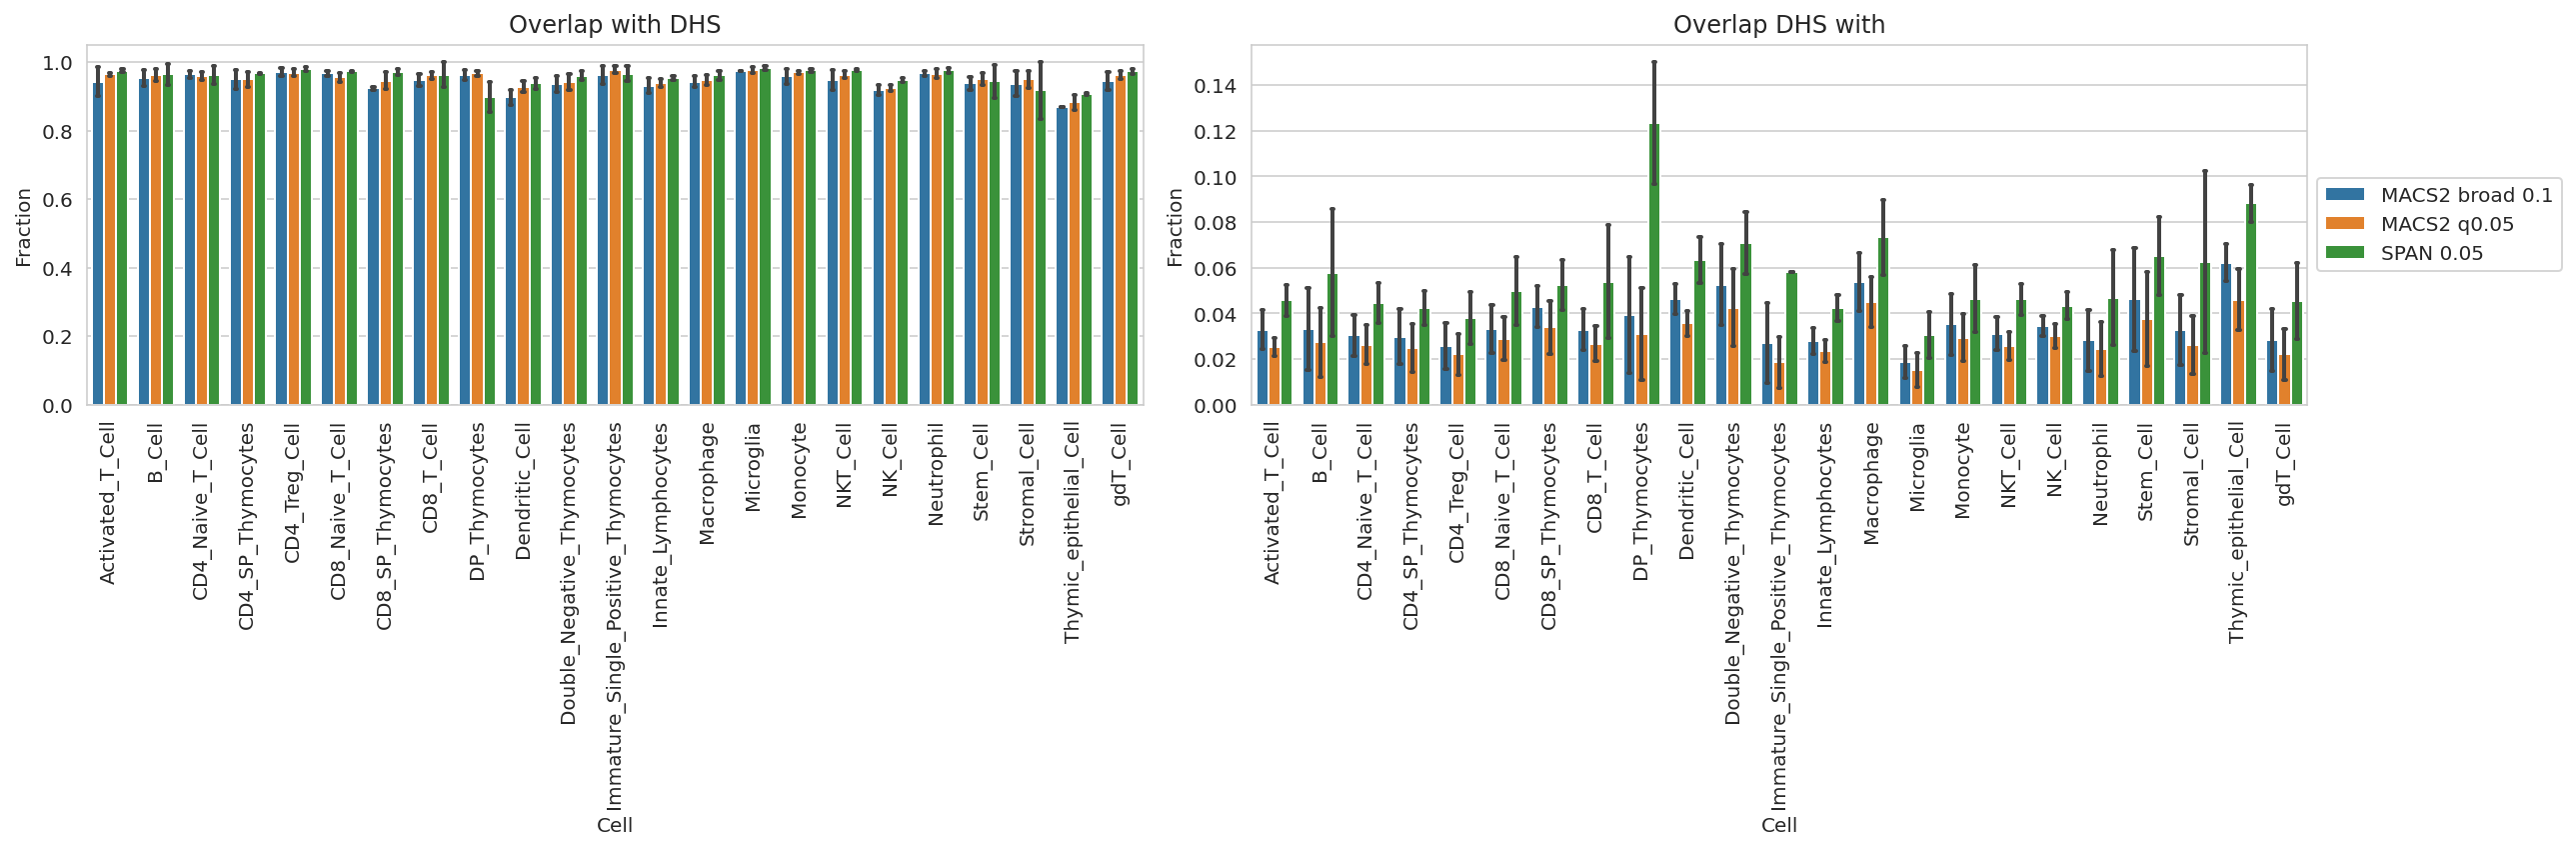

In [159]:
plt.figure(figsize=(18, 6))
# Plot 
ax = plt.subplot(1, 2, 1)
ax.title.set_text('Overlap with DHS')
sns.barplot(data=dhs_overlap[dhs_overlap['way']=='with_dhs'], x='name', y='overlap', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend().set_visible(False)

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Overlap DHS with')
t = dhs_overlap[dhs_overlap['way']=='dhs_with'].copy()
t['overlap'].clip(upper=0.15, inplace=True)
sns.barplot(data=t, x='name', y='overlap', hue='tool',
            errorbar='sd', capsize=.05, errwidth=2, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{PATH}/pics/dhs.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference

In [174]:
dfa

,srr,name,tool,file,peaks
0,SRR5799420,NK_Cell,MACS2 broad 0.1,/home/jetbrains/data/2023_Immgen/macs2/SRR5799...,42352
1,SRR5799390,Double_Negative_Thymocytes,MACS2 broad 0.1,/home/jetbrains/data/2023_Immgen/macs2/SRR5799...,27337
3,SRR5799418,NK_Cell,MACS2 broad 0.1,/home/jetbrains/data/2023_Immgen/macs2/SRR5799...,40350
4,SRR5799479,NKT_Cell,MACS2 broad 0.1,/home/jetbrains/data/2023_Immgen/macs2/SRR5799...,45535
5,SRR5799499,Macrophage,MACS2 broad 0.1,/home/jetbrains/data/2023_Immgen/macs2/SRR5799...,54214
...,...,...,...,...,...
735,SRR5799424,gdT_Cell,SPAN 0.05,/home/jetbrains/data/2023_Immgen/span/SRR57994...,28294
736,SRR5799388,Double_Negative_Thymocytes,SPAN 0.05,/home/jetbrains/data/2023_Immgen/span/SRR57993...,51791
737,SRR5799558,CD4_Treg_Cell,SPAN 0.05,/home/jetbrains/data/2023_Immgen/span/SRR57995...,19020
738,SRR5799529,Macrophage,SPAN 0.05,/home/jetbrains/data/2023_Immgen/span/SRR57995...,47387


In [176]:
diff_bench_df = pd.DataFrame(
    columns=['cell', 'srr', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()

for srr in tqdm(dfa['srr'].unique()):
    print(srr)
    t = dfa[(dfa['tool'] == 'SPAN 0.05') & (dfa['srr'] == srr)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    cell_name = t['name'].values[0]
    # Processing single tools information
    for tool in dfa['tool'].unique():
        if tool == 'SPAN 0.05':
            continue
        t = dfa[(dfa['tool'] == tool) & (dfa['srr'] == srr)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            !echo '' > {tf}
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            diff_bench_df.loc[len(diff_bench_df)] = (cell_name, srr, name, peaks)
diff_bench_df

  0%|          | 0/177 [00:00<?, ?it/s]

SRR5799420
SRR5799390
SRR5799418
SRR5799479
SRR5799499
SRR5799559
SRR5799395
SRR5799437
SRR5799387
SRR5799449
SRR5799535
SRR5799462
SRR5799460
SRR5799385
SRR5799434
SRR5799480
SRR5799533
SRR5799540
SRR5799500
SRR5799470
SRR5799519
SRR5799410
SRR5799456
SRR5799382
SRR5799463
SRR5799465
SRR5799414
SRR5799532
SRR5799451
SRR5799473
SRR5799536
SRR5799474
SRR5799448
SRR5799501
SRR5799512
SRR5799551
SRR5799511
SRR5799430
SRR5799508
SRR5799422
SRR5799409
SRR5799515
SRR5799505
SRR5799403
SRR5799472
SRR5799490
SRR5799531
SRR5799502
SRR5799416
SRR5799554
SRR5799388
SRR5799518
SRR5799539
SRR5799406
SRR5799468
SRR5799452
SRR5799442
SRR5799447
SRR5799407
SRR5799435
SRR5799524
SRR5799528
SRR5799389
SRR5799425
SRR5799436
SRR5799383
SRR5799504
SRR5799529
SRR5799399
SRR5799542
SRR5799483
SRR5799487
SRR5799510
SRR5799401
SRR5799445
SRR5799493
SRR5799477
SRR5799509
SRR5799503
SRR5799492
SRR5799537
SRR5799440
SRR5799484
SRR5799424
SRR5799446
SRR5799444
SRR5799432
SRR5799398
SRR5799453
SRR5799523
SRR5799496

,cell,srr,name,peaks
0,NK_Cell,SRR5799420,SPAN - MACS2 broad 0.1,2747
1,NK_Cell,SRR5799420,MACS2 broad 0.1 - SPAN,6335
2,NK_Cell,SRR5799420,SPAN - MACS2 q0.05,3915
3,NK_Cell,SRR5799420,MACS2 q0.05 - SPAN,4664
4,Double_Negative_Thymocytes,SRR5799390,SPAN - MACS2 broad 0.1,8708
...,...,...,...,...
703,CD8_Naive_T_Cell,SRR5799400,MACS2 q0.05 - SPAN,1010
704,Dendritic_Cell,SRR5799553,SPAN - MACS2 broad 0.1,3644
705,Dendritic_Cell,SRR5799553,MACS2 broad 0.1 - SPAN,5871
706,Dendritic_Cell,SRR5799553,SPAN - MACS2 q0.05,7582


Diff


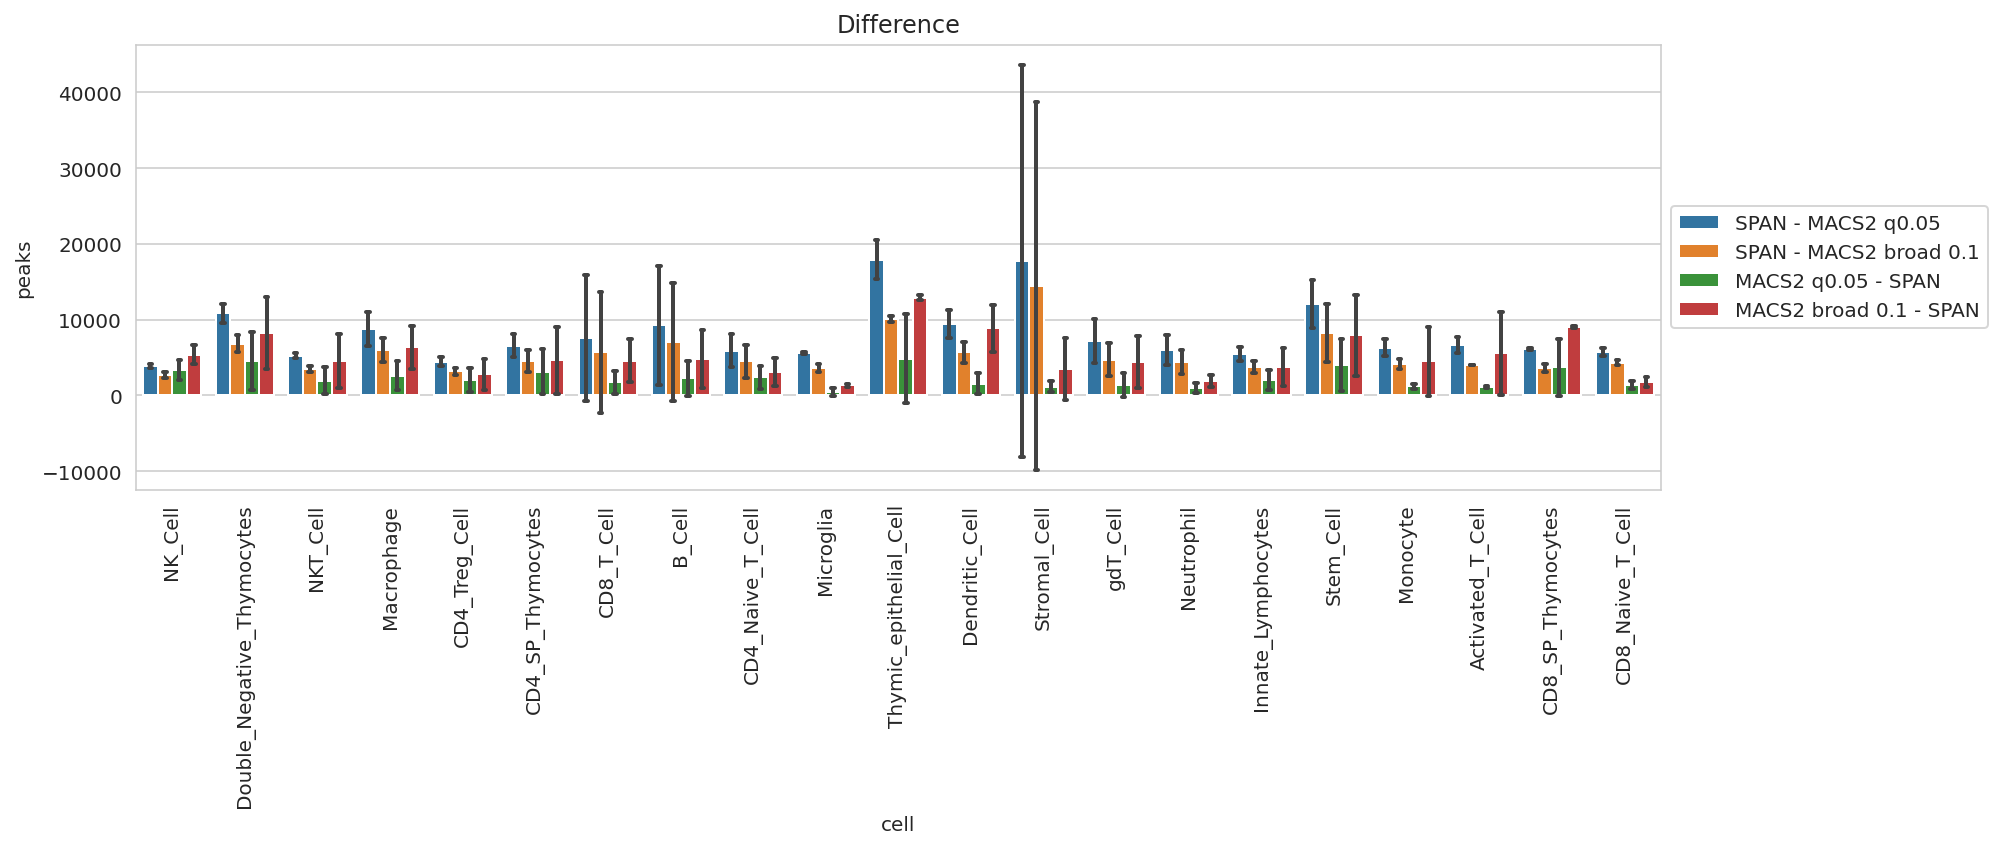

In [179]:
print('Diff')

plt.figure(figsize=(14, 6))
g_result = sns.barplot(data=diff_bench_df,
                       x='cell', y='peaks', hue='name',
                       errorbar='sd', capsize=.05, errwidth=2,
                       hue_order=['SPAN - MACS2 q0.05', 'SPAN - MACS2 broad 0.1',
                                  'MACS2 q0.05 - SPAN', 'MACS2 broad 0.1 - SPAN'])
plt.xticks(rotation=90)
plt.title('Difference')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Automatic markup

See `2023_Immgen/create_markup.sh` and `2023_Immgen/span_tuned` for tuning SPAN.